In [1]:
import itertools
import pickle

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import swifter

SAVE_DIR = "/path/to/dir/"

def plot_c(c,ax):
    ax.set_xlabel('year')
    ax.set_ylabel('# of Citation per year')
    ax.grid(True)
    ax.plot(range(len(c)),c,color='black')

In [2]:
# execute "pip install git+ssh://git@github.com:TM82/pyhibernator.git" or  "git clone git@github.com:TM82/pyhibernator.git \ cd pyhibernator \pip install ."
import  pyhibernator

# Read

In [3]:
target_papers = pd.read_pickle(SAVE_DIR+'PHYS/papers_arcp_subj_forpublic.pickle')
target_papers.shape

(8122477, 7)

In [4]:
target_papers.head()

,authids,subjs,year,doctype,c_history,c_history_wo_self,citation_chwos
eid,,,,,,,
85073619453,"[35725858900, 57217608353]",[PHYS],2019,ar,"[1, 3]","[1, 2]",3
85073489235,"[57211327415, 14058618400, 14031440100]","[CHEM, ENGI, PHYS, MATE]",2019,ar,"[0, 0]","[0, 0]",0
85073489247,"[57188657265, 36128499600, 56924114700, 571886...","[PHYS, CHEM]",2019,ar,"[0, 1]","[0, 0]",0
85073619521,"[36134224000, 26668051000, 55651526300, 700338...",[PHYS],2019,ar,"[0, 2]","[0, 1]",1
85073556992,"[57202321709, 57211332485]","[PHYS, MATE]",2019,ar,"[0, 0]","[0, 0]",0


- column explanation
    - eid: int
        - Paper ID in Scopus Dataset
    - authids: list[int]
        - Author IDs list
    - subjs: list[str]
        - All Science Journal Classification Codes for published journal
        - Limited to papers which include "PHYS"
    - year: int
        - Publication Year
    - doctype: str
        - Document Type
        - Limited to "ar" or "cp"
    - c_history: list[int]
        - Citation History from "Publication Year" to 2020 using reference data
        - c_history[0] represents the number of citation in "Publication Year".
    - c_history_wo_self: list[int]
        - Citation History excluding self-citaiton.
        - If any one of the authids is overlapped detected by "authids" columns, it is considered a self-citation.
    - citation_chwos: int
        - sum of "c_history_wo_self"

# Extract hibernator

In [5]:
dic_SBs = dict()

# Since s + a = 20 for Average method, all hibernators should be extracted from ~2000 

SLEEP_YEAR = 10
SLEEP_CITATION = 1
AWAKE_YEAR = 10
AWAKE_CITATION = 5

YEAR_MAX = 2020

## Naive(c3<=2, c>=100)

In [7]:
s = 5 # sleep length
cs = 2 # depth of sleep
ca = 100 # Today's minimum Citation

df = target_papers[target_papers['year'].map(lambda x: x <= YEAR_MAX - SLEEP_YEAR - AWAKE_YEAR)].copy()
dic_SBs['glanzel'] = df[df['c_history_wo_self'].map(lambda c_history: pyhibernator.Naive.extract(c=c_history,s=s,cs=cs,ca=ca))].copy()
print(dic_SBs['glanzel'].shape)

(2297, 7)


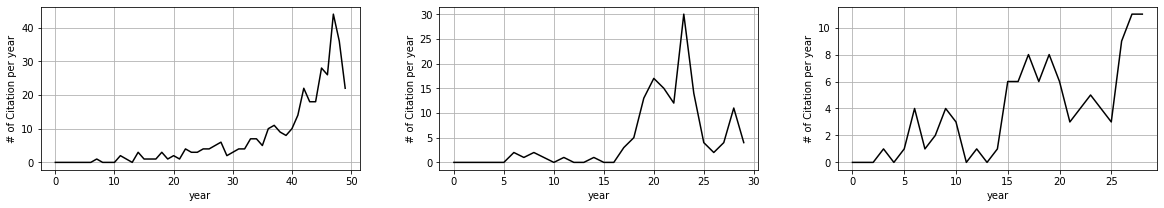

In [8]:
fig = plt.figure(figsize=(20,3))
fig.subplots_adjust(wspace=0.25, hspace=0)
for i in range(3):
    ax = fig.add_subplot(1,3,i+1)
    plot_c(dic_SBs['glanzel'].iloc[i]['c_history_wo_self'], ax)
plt.show()

## Average(cs=1,s=10,a=10,ca=5)

In [13]:
df = target_papers[target_papers['year'].map(lambda x: x <= YEAR_MAX - SLEEP_YEAR - AWAKE_YEAR)].copy()
dic_SBs['raan'] = df[df['c_history_wo_self'].map(lambda c_history: pyhibernator.Average.extract(c=c_history,s=SLEEP_YEAR,cs=SLEEP_CITATION,a=AWAKE_YEAR,ca=AWAKE_CITATION))].copy()
print(dic_SBs['raan'].shape)

(1220, 7)


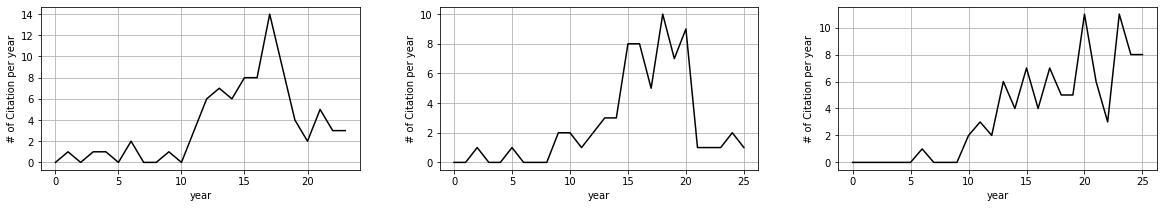

In [14]:
fig = plt.figure(figsize=(20,3))
fig.subplots_adjust(wspace=0.25, hspace=0)
for i in range(3):
    ax = fig.add_subplot(1,3,i+1)
    plot_c(dic_SBs['raan'].iloc[i]['c_history_wo_self'], ax)
plt.show()

## DNIC(c>=50, t_peak>th, DNIC_peak>1.6, DNIC_beforepeak<1)

In [10]:
def func(row):
    return pyhibernator.DNIC.extract(
        c=row['c_history_wo_self'],
        subjs=row['subjs'],
        year=row['year'], 
        ekj_dic=ekj_dic,
        c_peak = 1.6,
        c_before_peak = 1.0
    )

ekj_dic = pyhibernator.DNIC.get_ekj(c_list=target_papers['c_history_wo_self'].tolist(),subjs_list=target_papers['subjs'].tolist(),year_list=target_papers['year'].tolist())
df = target_papers[target_papers['citation_chwos']>=50].copy()
df = df[df['year'].map(lambda x: x <= YEAR_MAX - SLEEP_YEAR - AWAKE_YEAR)].copy()
dic_SBs['bornmann'] = df[df.apply(func,axis=1)].copy()
print(dic_SBs['bornmann'].shape)

(1146, 7)


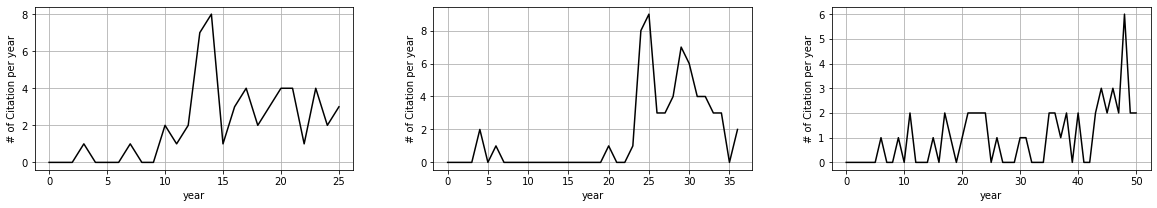

In [11]:
fig = plt.figure(figsize=(20,3))
fig.subplots_adjust(wspace=0.25, hspace=0)
for i in range(3):
    ax = fig.add_subplot(1,3,i+1)
    plot_c(dic_SBs['bornmann'].iloc[i]['c_history_wo_self'], ax)
plt.show()

## Citation Angle(c>=50, c_before_average<=2, c_peak>20, β2>5°, t2-t1>10, Typical SB)

In [11]:
df = target_papers[target_papers['citation_chwos']>=50].copy()
df = df[df['year'].map(lambda x: x <= YEAR_MAX - SLEEP_YEAR - AWAKE_YEAR)].copy()
dic_SBs['ye'] = df[df['c_history_wo_self'].map(lambda c_history: pyhibernator.CitationAngle.extract(
    c=c_history,
    c_before_average=2,
    c_peak=20,
    angle_after=5,
    span=10
))].copy()
print(dic_SBs['ye'].shape)

(910, 7)


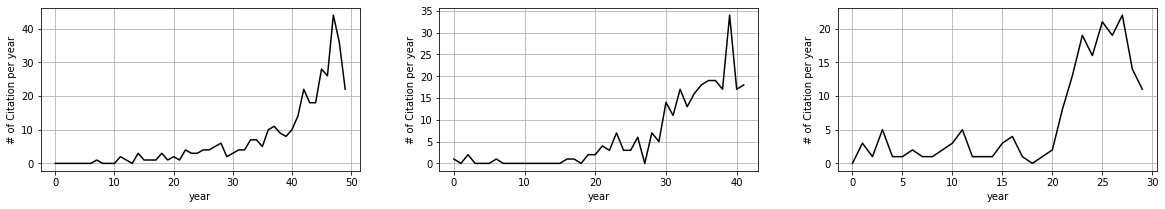

In [12]:
fig = plt.figure(figsize=(20,3))
fig.subplots_adjust(wspace=0.25, hspace=0)
for i in range(3):
    ax = fig.add_subplot(1,3,i+1)
    plot_c(dic_SBs['ye'].iloc[i]['c_history_wo_self'], ax)
plt.show()

## Quartile(c>=50, 98%<C50)

In [13]:
def func(row):
    return pyhibernator.Quartile.extract(
        c50=row['c50'],
        subjs=row['subjs'],
        year=row['year'], 
        c_dic_before=c25_dic,
        c_dic_after=c98_dic
    )

df = target_papers[target_papers['year'].map(lambda x: x <= YEAR_MAX - SLEEP_YEAR - AWAKE_YEAR)].copy()
df['c50'] = df['c_history_wo_self'].map(pyhibernator.Quartile.get_c50)
df = df[df['citation_chwos']>=5].copy() # As in original paper, the target papers for calculating "C25" and "C75" are bounded to papers which get more than 5 citations

c25_dic = pyhibernator.Quartile.get_c_dic(c50_list=df['c50'].tolist(),subjs_list=df['subjs'].tolist(),year_list=df['year'].tolist(),rate=0.25)
c98_dic = pyhibernator.Quartile.get_c_dic(c50_list=df['c50'].tolist(),subjs_list=df['subjs'].tolist(),year_list=df['year'].tolist(),rate=0.98)

df = df[df['citation_chwos']>=50].copy()
dic_SBs['costas'] = df[df.apply(func,axis=1)].copy()
print(dic_SBs['costas'].shape)

(1865, 8)


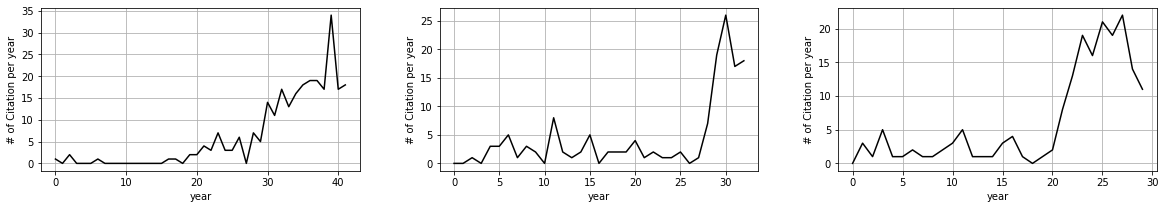

In [15]:
fig = plt.figure(figsize=(20,3))
fig.subplots_adjust(wspace=0.25, hspace=0)
for i in range(3):
    ax = fig.add_subplot(1,3,i+1)
    plot_c(dic_SBs['costas'].iloc[i]['c_history_wo_self'], ax)
plt.show()

## Exponential Quartile(c>=50,k=2)

In [16]:
k = 2

df = target_papers[target_papers['citation_chwos']>=50].copy()
df = df[df['year'].map(lambda x: x <= YEAR_MAX - SLEEP_YEAR - AWAKE_YEAR)].copy()
dic_SBs['li_exp'] = df[df['c_history_wo_self'].map(lambda c_history: pyhibernator.ExponentialQuartile.extract(c=c_history,k=k))].copy()
print(dic_SBs['li_exp'].shape)

(241, 7)


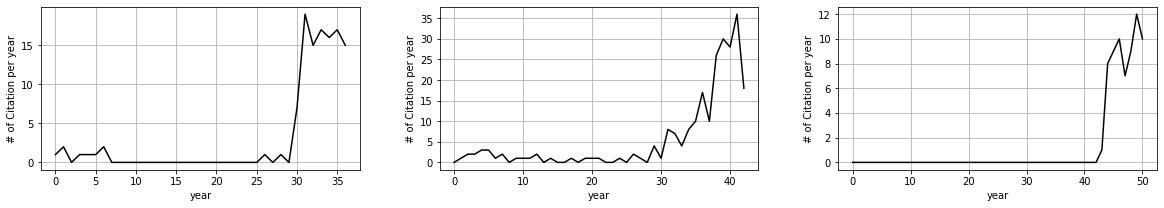

In [17]:
fig = plt.figure(figsize=(20,3))
fig.subplots_adjust(wspace=0.25, hspace=0)
for i in range(3):
    ax = fig.add_subplot(1,3,i+1)
    plot_c(dic_SBs['li_exp'].iloc[i]['c_history_wo_self'], ax)
plt.show()

## Beauty Coefficient(c>=50,B>=149.65)

In [15]:
df = target_papers[target_papers['citation_chwos']>=50].copy()
df = df[df['year'].map(lambda x: x <= YEAR_MAX - SLEEP_YEAR - AWAKE_YEAR)].copy()
df['B'] = df['c_history_wo_self'].map(lambda c_history: pyhibernator.BeautyCoefficient.score(c=c_history))
dic_SBs['ke'] = df.sort_values('B',ascending=False).iloc[:len(dic_SBs['raan'])].copy()
print(dic_SBs['ke'].shape)

(1220, 8)


In [19]:
print(dic_SBs['ke']['B'].min())
print(dic_SBs['ke']['B'].max())

149.64888888888885
3222.130554278618


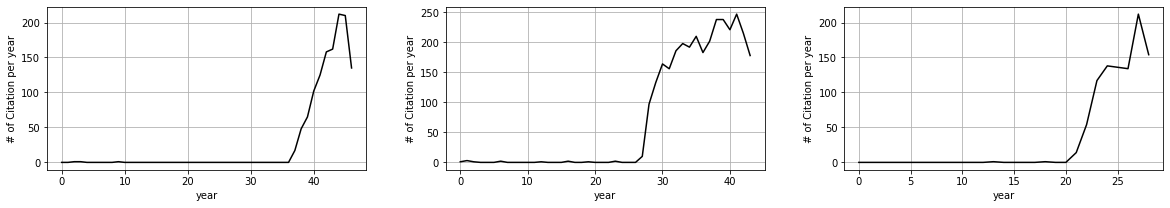

In [20]:
fig = plt.figure(figsize=(20,3))
fig.subplots_adjust(wspace=0.25, hspace=0)
for i in range(3):
    ax = fig.add_subplot(1,3,i+1)
    plot_c(dic_SBs['ke'].iloc[i]['c_history_wo_self'], ax)
plt.show()

## Beauty Coefficient Cumulative Percentage(c>=50, Bcp>=10.83)

In [21]:
df = target_papers[target_papers['citation_chwos']>=50].copy()
df = df[df['year'].map(lambda x: x <= YEAR_MAX - SLEEP_YEAR - AWAKE_YEAR)].copy()
df['Bcp'] = df['c_history_wo_self'].map(pyhibernator.BeautyCoefficientCumulativePercentage.score)
dic_SBs['du'] = df.sort_values('Bcp',ascending=False).iloc[:len(dic_SBs['raan'])].copy()

In [22]:
print(dic_SBs['du']['Bcp'].min())
print(dic_SBs['du']['Bcp'].max())

10.829391891891891
21.727272727272727


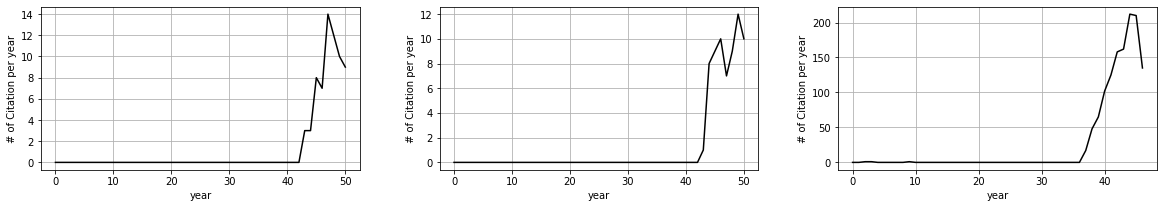

In [23]:
fig = plt.figure(figsize=(20,3))
fig.subplots_adjust(wspace=0.25, hspace=0)
for i in range(3):
    ax = fig.add_subplot(1,3,i+1)
    plot_c(dic_SBs['du'].iloc[i]['c_history_wo_self'], ax)
plt.show()

## Citation Delay(c>=50, D>=0.789)

In [24]:
df = target_papers[target_papers['citation_chwos']>=50].copy()
df = df[df['year'].map(lambda x: x <= YEAR_MAX - SLEEP_YEAR - AWAKE_YEAR)].copy()
df['CD'] = df['c_history_wo_self'].map(pyhibernator.CitationDelay.score)
dic_SBs['wang'] = df.sort_values('CD',ascending=False).iloc[:len(dic_SBs['raan'])].copy()

In [25]:
print(dic_SBs['wang']['CD'].min())
print(dic_SBs['wang']['CD'].max())

0.7886549340037712
0.9445454545454546


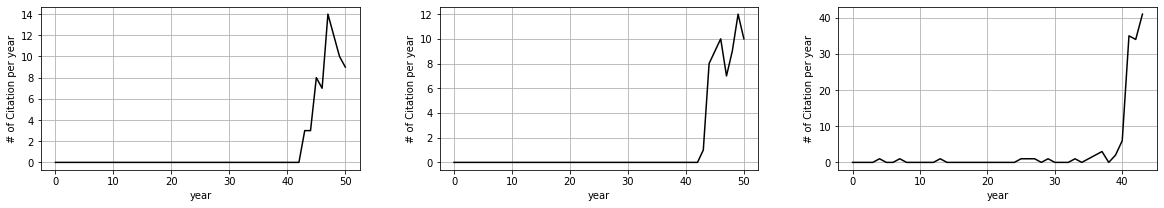

In [26]:
fig = plt.figure(figsize=(20,3))
fig.subplots_adjust(wspace=0.25, hspace=0)
for i in range(3):
    ax = fig.add_subplot(1,3,i+1)
    plot_c(dic_SBs['wang'].iloc[i]['c_history_wo_self'], ax)
plt.show()

## Adjusted Gini Coefficient(c>=50,Gs>=0.577)

In [27]:
df = target_papers[target_papers['citation_chwos']>=50].copy()
df = df[df['year'].map(lambda x: x <= YEAR_MAX - SLEEP_YEAR - AWAKE_YEAR)].copy()
df['Gs'] = df['c_history_wo_self'].map(pyhibernator.AdjustedGiniCoefficient.score)
dic_SBs['li'] = df.sort_values('Gs',ascending=False).iloc[:len(dic_SBs['raan'])].copy()

In [28]:
print(dic_SBs['li']['Gs'].min())
print(dic_SBs['li']['Gs'].max())

0.5773098680075425
0.889090909090909


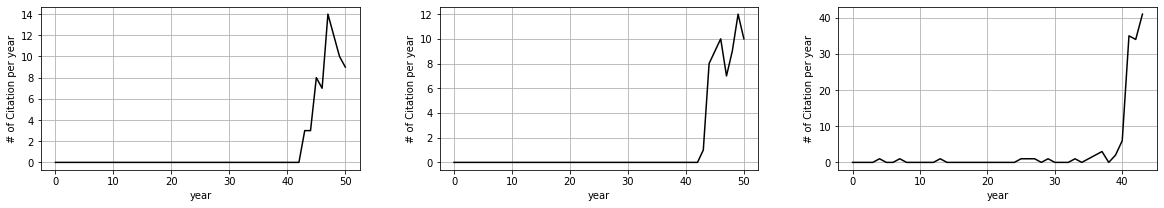

In [29]:
fig = plt.figure(figsize=(20,3))
fig.subplots_adjust(wspace=0.25, hspace=0)
for i in range(3):
    ax = fig.add_subplot(1,3,i+1)
    plot_c(dic_SBs['li'].iloc[i]['c_history_wo_self'], ax)
plt.show()

## K Value(c>=50, K>0.826)

In [30]:
df = target_papers[target_papers['citation_chwos']>=50].copy()
df = df[df['year'].map(lambda x: x <= YEAR_MAX - SLEEP_YEAR - AWAKE_YEAR)].copy()
df['K'] = df['c_history_wo_self'].map(pyhibernator.KValue.score)
dic_SBs['teixeira'] = df.sort_values('K',ascending=False).iloc[:len(dic_SBs['raan'])].copy()
print(dic_SBs['teixeira'].shape)

(1220, 8)


In [31]:
print(dic_SBs['teixeira']['K'].min())
print(dic_SBs['teixeira']['K'].max())

0.8256698911979103
1.0


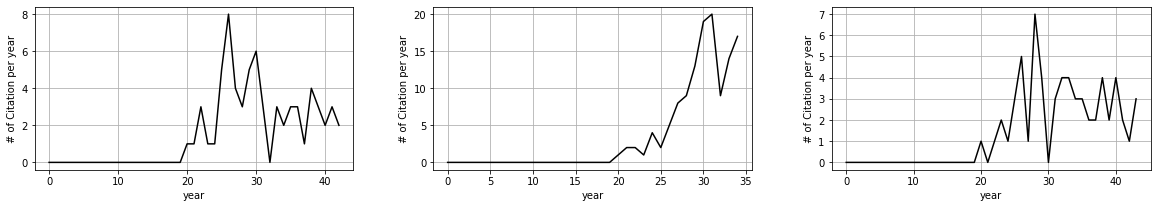

In [32]:
fig = plt.figure(figsize=(20,3))
fig.subplots_adjust(wspace=0.25, hspace=0)
for i in range(3):
    ax = fig.add_subplot(1,3,i+1)
    plot_c(dic_SBs['teixeira'].iloc[i]['c_history_wo_self'], ax)
plt.show()

## null(c>=50)

In [33]:
N_NULL = 10 #num of montecarlo simulation

In [34]:
df = target_papers[target_papers['citation_chwos']>=50].copy()
df = df[df['year'].map(lambda x: x <= YEAR_MAX - SLEEP_YEAR - AWAKE_YEAR)].copy()
idx_exists = set(list(itertools.chain.from_iterable([dic_SBs[k].index for k in dic_SBs])))
df = df.drop(list(idx_exists))

dic_SBs_null = dict()
for i in range(N_NULL):
    dic_SBs_null[i] = df.sample(len(dic_SBs['raan']),random_state=i).copy()

# Save

In [35]:
with open(SAVE_DIR+'PHYS/dic_SBs_PHYS.pickle','wb') as f:
    pickle.dump(dic_SBs,f)
with open(SAVE_DIR+'PHYS/dic_SBs_null_PHYS.pickle','wb') as f:
    pickle.dump(dic_SBs_null,f)